In [ ]:
"""
This is a win prediction model for an MLB season.

Currently at 60% accuracy within 5 wins. (6/5/25)
Currently at 74% accuracy within 5 wins. (7/5/25)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [90]:
#load teams
teams = pd.read_csv('../csv/teams.csv')

#only show seasons after 1962 (beginning of 162-game seasons)
teams = teams[teams['yearID'] > 1962]

#remove non-quantitative values
teams = teams.drop(columns = ['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'name', 'park', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'])

#only show teams that played >150 game in a season
teams = teams[teams['G'] > 150]

#only show teams with attendance tracking
teams = teams[teams['attendance'] > 0]

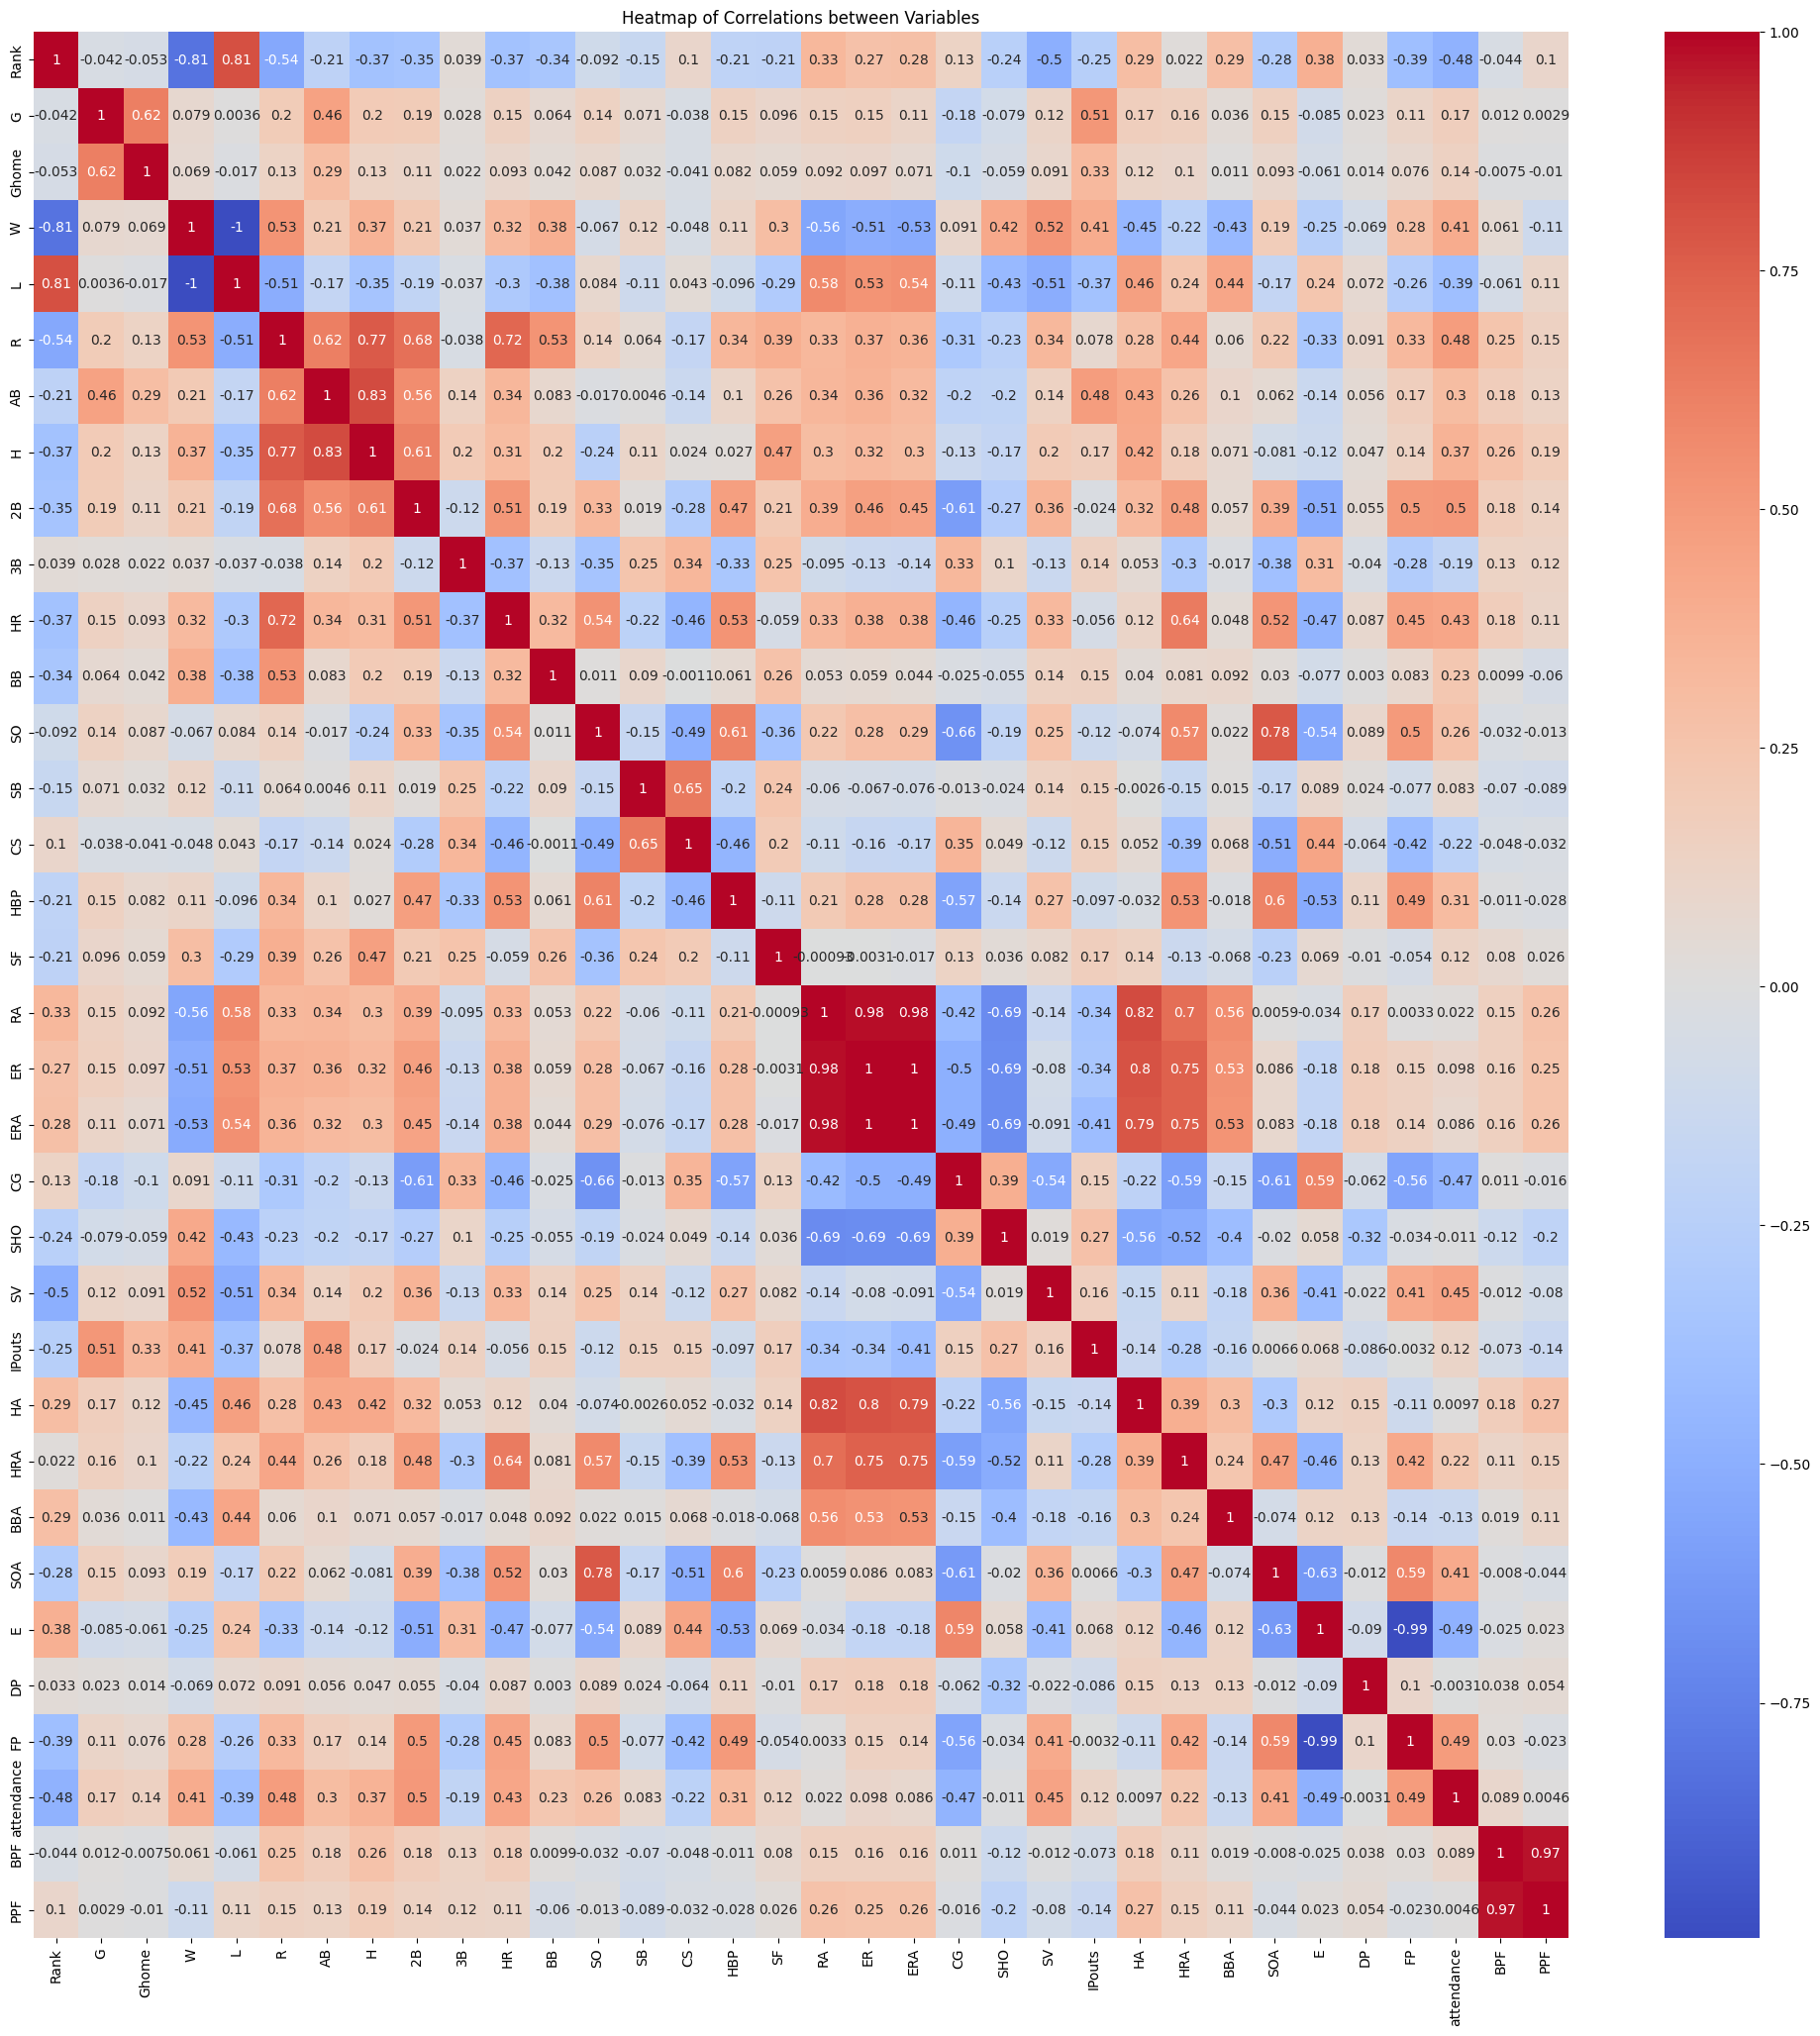

In [91]:
fig, ax = plt.subplots(figsize=(25,25))

corr = teams.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

ax.set_title("Heatmap of Correlations between Variables")

plt.show()

In [92]:
#Drop team stats we don't want to train on
teams = teams.drop(columns = ['Rank', 'G', 'Ghome', 'L', 'AB', 'CS', 'HBP', 'ERA', 'SV', 'CG', 'SHO','IPouts', 'DP', 'attendance', 'BPF', 'PPF', 'SOA'])

#Team stats the model is trained on -> [R (runs), H (hits), 2B (doubles), 3B (triples), HR (home runs), BB (walks), SO (strikeouts-batting), 
# SB (stolen bases), SF (sac flys), RA (runs allowed), ER (earned runs), HA (hits allowed), HRA (home runs allowed), 
# BBA (walks allowed), E (errors), FP (fielding percentage)]

In [93]:
def interval_accuracy(y_test, predictions, interval):
    """
    Computes the proportion of predictions within a specified interval of the true values.

    Parameters:
    - y_test: Array of true values from n samples.
    - predictions: Array of predicted values from n samples.
    - interval: positive integer plus/minus deviation from true value
    """
    y_test = np.array(y_test)
    predictions = np.array(predictions)
    correct = np.abs(y_test - predictions) <= interval
    return np.mean(correct)


In [94]:
#Split data into data we want to use to make predictions and the statistic we want to predict
X = teams.drop(columns = ['W'])
y = teams['W']

#Implement a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Use a decision tree model to make predictions and fit the data
model = RandomForestRegressor(max_depth=5)
model.fit(X_train.values, y_train)

predictions = model.predict(X_test.values)

#Calculate root mean squared error (on average how many wins is the model off by)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

#Calculate accuracy (# of wins within given interval)
accuracy = interval_accuracy(y_test, predictions, 5)

accuracy, rmse

(np.float64(0.7435064935064936), np.float64(4.483971418539408))

In [95]:
#Implement cross-validation

def within_range(y_test, predictions, tol):
    return np.mean(np.abs(y_test - predictions) <= tol)

range_scorer = make_scorer(lambda y_test, predictions: within_range(y_test, predictions, 5))

cross_score = cross_val_score(model, X, y, cv=10, scoring=range_scorer)

cross_score.mean()

np.float64(0.7421908157202275)